# 2D Motion

### Introduction

We live in a quite complex world, where motion is considered a synonym of life. In fact, everything we do is related to motion.

Our world is composed of 3 dimensions (3D) in which you can move (jump, run, swim, do backflips, etc.). In this lab, we will handle a big part of that complexity of the world we live in - Motion in two dimensions.

### What is it?

2D motion is a motion where 2 dimensions are used. Now, compared to 1 dimension, objects in 2 dimensions experience the force from more sides. Such motion is not significantly different from 3D motion, since it allows us to model interaction of objects and the earth much more simply. The main desire to use 2 dimensions is to see how objects will experience gravity.

### Example

The cliché example is a projectile motion - a parabalistic trajectories of thrown objects that under gravitation will eventually fall down. Such a process might be visualized differently. For instance, you may throw a rock or a ball, you may speed up and jump up the hillock on your bike or you might think of the Earth moving around the sun. All of that is an example of projectile motion. 

In the past, our ancestors had been using dangerous weapons called catapults to destroy their enemies' fortresses and to conquer cities, however, they did not know any kinematics formulae, they used a method of trial and error to understand the relationship between the angle and the distance cannonball flies. Today, thanks to many curious people as Galileo Galilei and Isaac Newton we know how to calculate complex trajectories that allow us to control the multistage rockets.

### Formulas

2D Motion might be calculated using the following formulas:

Fall Velocity: $\vec{v}_y=\vec{v}_{y0}+\vec{a}t=\vec{v}_{y0}+\vec{g}t$\
Move Velocity: $\vec{v}=\vec{v_0}+\vec{a}t$\
Position: $x=x_0+\vec{v}t+\frac{1}{2}\vec{a}t^2$


# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

# simulation
from dm_control import mjcf, mujoco
from dm_control.mujoco import engine

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


Set nice theme for plots

In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [4]:
# global
viscosity = 0.00002  # Air Resistance

# simulation constants
# speed [m/s]
v = 20
# angle in degrees
angle = 30

platform_length = 1000  # [m]

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

Convert degrees to radians

In [5]:
angle_rad = angle * np.pi / 180

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [6]:
if not IS_COLAB:
  import os, sys

  module_path = os.path.abspath(os.path.join(".."))
  if module_path not in sys.path:
      sys.path.append(module_path)

  from scene import Scene

else:
  from extraphi.mechanics.scene import Scene

### Objects of Interest

Here we create all the objects that will interact in the world. To model `2D motion` one might create a box that is shot in the sky under a specific angle.

In [7]:
class Box(object):

    def __init__(self, size: float) -> None:
        self.model = mjcf.RootElement(model="box")

        self.wrapper = self.model.worldbody.add("body", name="wrapper", pos=[0, 0, 0])

        self.box = self.wrapper.add("body", name="box", pos=[0, 0, 0])
        self.box_geom = self.box.add(
            "geom",
            name="box_geom",
            type="box",
            size=[size, size, size],
            mass=1,
            rgba=[1, 0, 0, 1],
            condim=6,
        )

        self.hidden_box_geom = self.wrapper.add(
            "geom",
            name="hidden_box_geom",
            type="box",
            size=[size, size, size],
            mass=1,
            rgba=[0, 0, 0, 0],
            contype=0,
            conaffinity=0,
        )

        self.camera = self.wrapper.add(
            "camera",
            name="front",
            pos=[0, -4, 0],
            euler=[90, 0, 0],
            mode="trackcom",
            fovy=45,
        )

        self.move = self.box.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.box.add("joint", name="fall", type="slide", axis=[0, 0, 1])

        self.box.add("light", directional=False, pos=[0, 0, 10], dir=[0, 0, -1])

### World Model

Collecting everything into one general model.

In [8]:
class Model(object):

    def __init__(self, platform_length: float) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width
        self.model.visual.map.znear = 0.001

        # set the simulation constants
        self.model.option.viscosity = viscosity

        # create the environment (ground)
        self.scene = Scene(length=platform_length, width=10, condim=6)
        self.scene_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.scene_site.attach(self.scene.model)

        box_size = 0.3

        # add the box
        self.box = Box(box_size)
        box_site = self.model.worldbody.add("site", pos=[0, 0, box_size * 1.5])
        box_site.attach(self.box.model)

## Simulation

Initializing the `physics` of the simulation and verifying the environment by rendering a picture of the simulation world.

In [9]:
model = Model(platform_length).model
physics = mjcf.Physics.from_mjcf_model(model)

Creating a new movable camera.

In [10]:
camera = engine.MovableCamera(physics, height, width)
lookat = (
    abs(physics.named.data.geom_xpos["box/box_geom"].copy())
    - abs(physics.named.data.geom_xpos["box/hidden_box_geom"].copy())
) / 2
camera.set_pose(lookat=lookat, distance=8, azimuth=90, elevation=0)

First of all, the environment must be verified by rendering a picture.

""

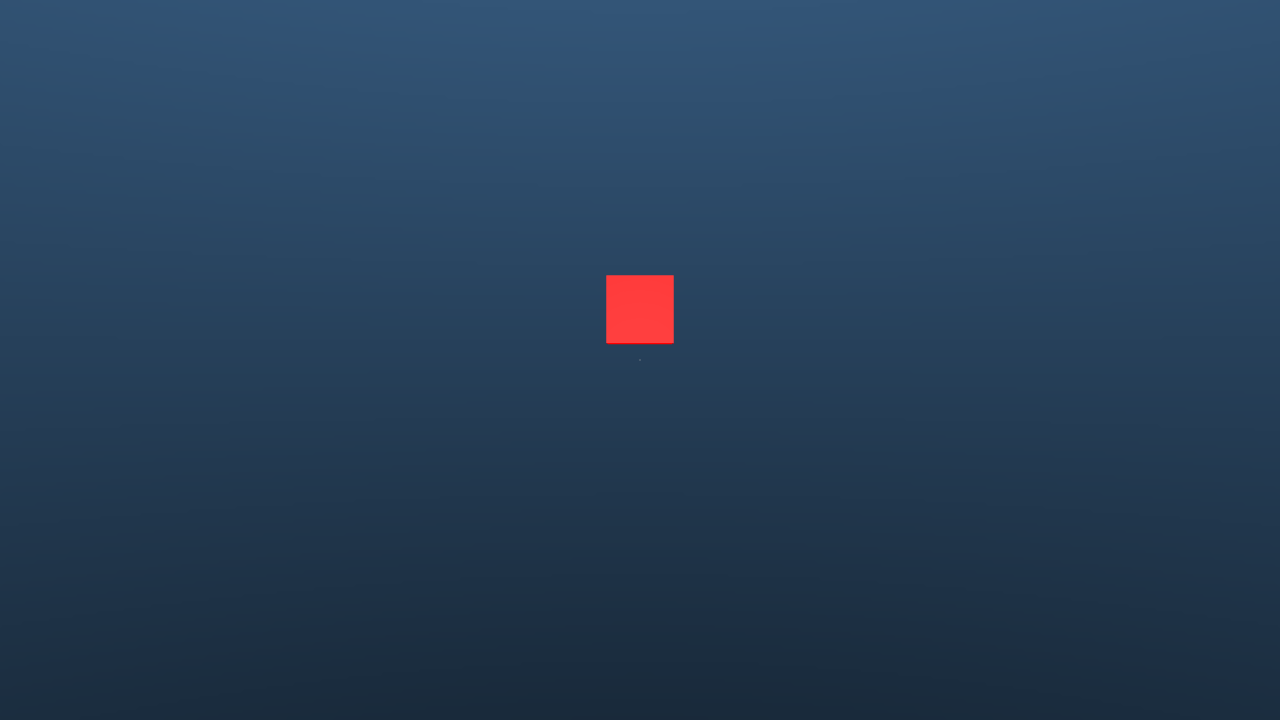

In [11]:
mediapy.show_image(camera.render().copy())

Get IDs of the objects

In [12]:
box_id = physics.model.name2id("box/box_geom", "geom")
ground_id = physics.model.name2id("scene/platform", "geom")
box_track_id = physics.model.name2id("box/wrapper", "body")
box_id, ground_id, box_track_id

(2, 0, 3)

### Scene Modification

These functions allow to render some objects (trajectories, in this case) that will be visible, but will not interact.

In [13]:
def add_visual_capsule(scene, point1, point2, radius, rgba):
    """Adds one capsule to an mjvScene."""
    if scene.ngeom >= scene.maxgeom:
        return
    scene.ngeom += 1  # increment ngeom
    # initialise a new capsule, add it to the scene using mjv_connector
    mujoco.mjv_initGeom(
        scene.geoms[scene.ngeom - 1],
        mujoco.mjtGeom.mjGEOM_CAPSULE,
        np.ones(3),
        np.zeros(3),
        np.zeros(9),
        rgba.astype(np.float32),
    )
    mujoco.mjv_connector(
        scene.geoms[scene.ngeom - 1],
        mujoco.mjtGeom.mjGEOM_CAPSULE,
        radius,
        point1,
        point2,
    )


def modify_scene(physics, scn, position):
    """Draw position trace"""
    if len(position) > 1:
        for i in range(len(position) - 1):
            rgba = np.array([1, 0, 0, 1])
            radius = 0.1
            point1 = position[i]
            point2 = position[i + 1]
            add_visual_capsule(scn, point1, point2, radius, rgba)

    return position

### Simulation Loop

In [14]:
physics.reset()

frames = []
timevals = []
velocity = []
position = []

impact_time_index = None
accelerated = False

while physics.time() < duration:
    physics.step()

    if not accelerated and physics.time() > 1.0:
        # set inital velocity
        physics.named.data.qvel["box/move"] = v * np.cos(angle_rad)
        physics.named.data.qvel["box/fall"] = v * np.sin(angle_rad)
        accelerated = True

    if impact_time_index is not None and physics.time() - impact_time_index > 3.0:
        break

    for i, c in enumerate(physics.data.contact):
        if (
            impact_time_index is None
            and accelerated
            and box_id in c.geom
            and ground_id in c.geom
            and physics.named.data.qvel["box/fall"] < 0.000001
        ):
            impact_time_index = physics.time()
            physics.named.data.qvel["box/move"] = 0

    if accelerated and impact_time_index is None:
        timevals.append(physics.data.time)
        velocity.append(physics.named.data.qvel[:].copy())
        position.append(physics.named.data.geom_xpos["box/box_geom"].copy())

    # modify camera view
    distance = camera.get_pose().distance + 2 * v * physics.model.opt.timestep
    lookat = (
        abs(physics.named.data.geom_xpos["box/box_geom"].copy())
        - abs(physics.named.data.geom_xpos["box/hidden_box_geom"].copy())
    ) / 2

    if len(frames) < physics.data.time * framerate:
        scene_callback = None
        if accelerated:
            scene_callback = lambda _physics, _scn: modify_scene(
                _physics, _scn, position
            )
        camera = engine.MovableCamera(
            physics,
            height,
            width,
            scene_callback=scene_callback,
        )
        camera.set_pose(lookat, distance, azimuth=90, elevation=0)
        pixels = camera.render().copy()
        frames.append(pixels)

In [15]:
# Simulate and display video.
mediapy.show_video(frames, fps=framerate)

Save the rendered video

In [16]:
video_name = f"2d_motion" if IS_COLAB else f"../../output/2d_motion"
mediapy.write_video(video_name + ".mp4", images=frames, fps=framerate)

## Simulation Data Visualization

Convert data into numpy array to have more features

In [17]:
velocity = np.array(velocity)
position = np.array(position)

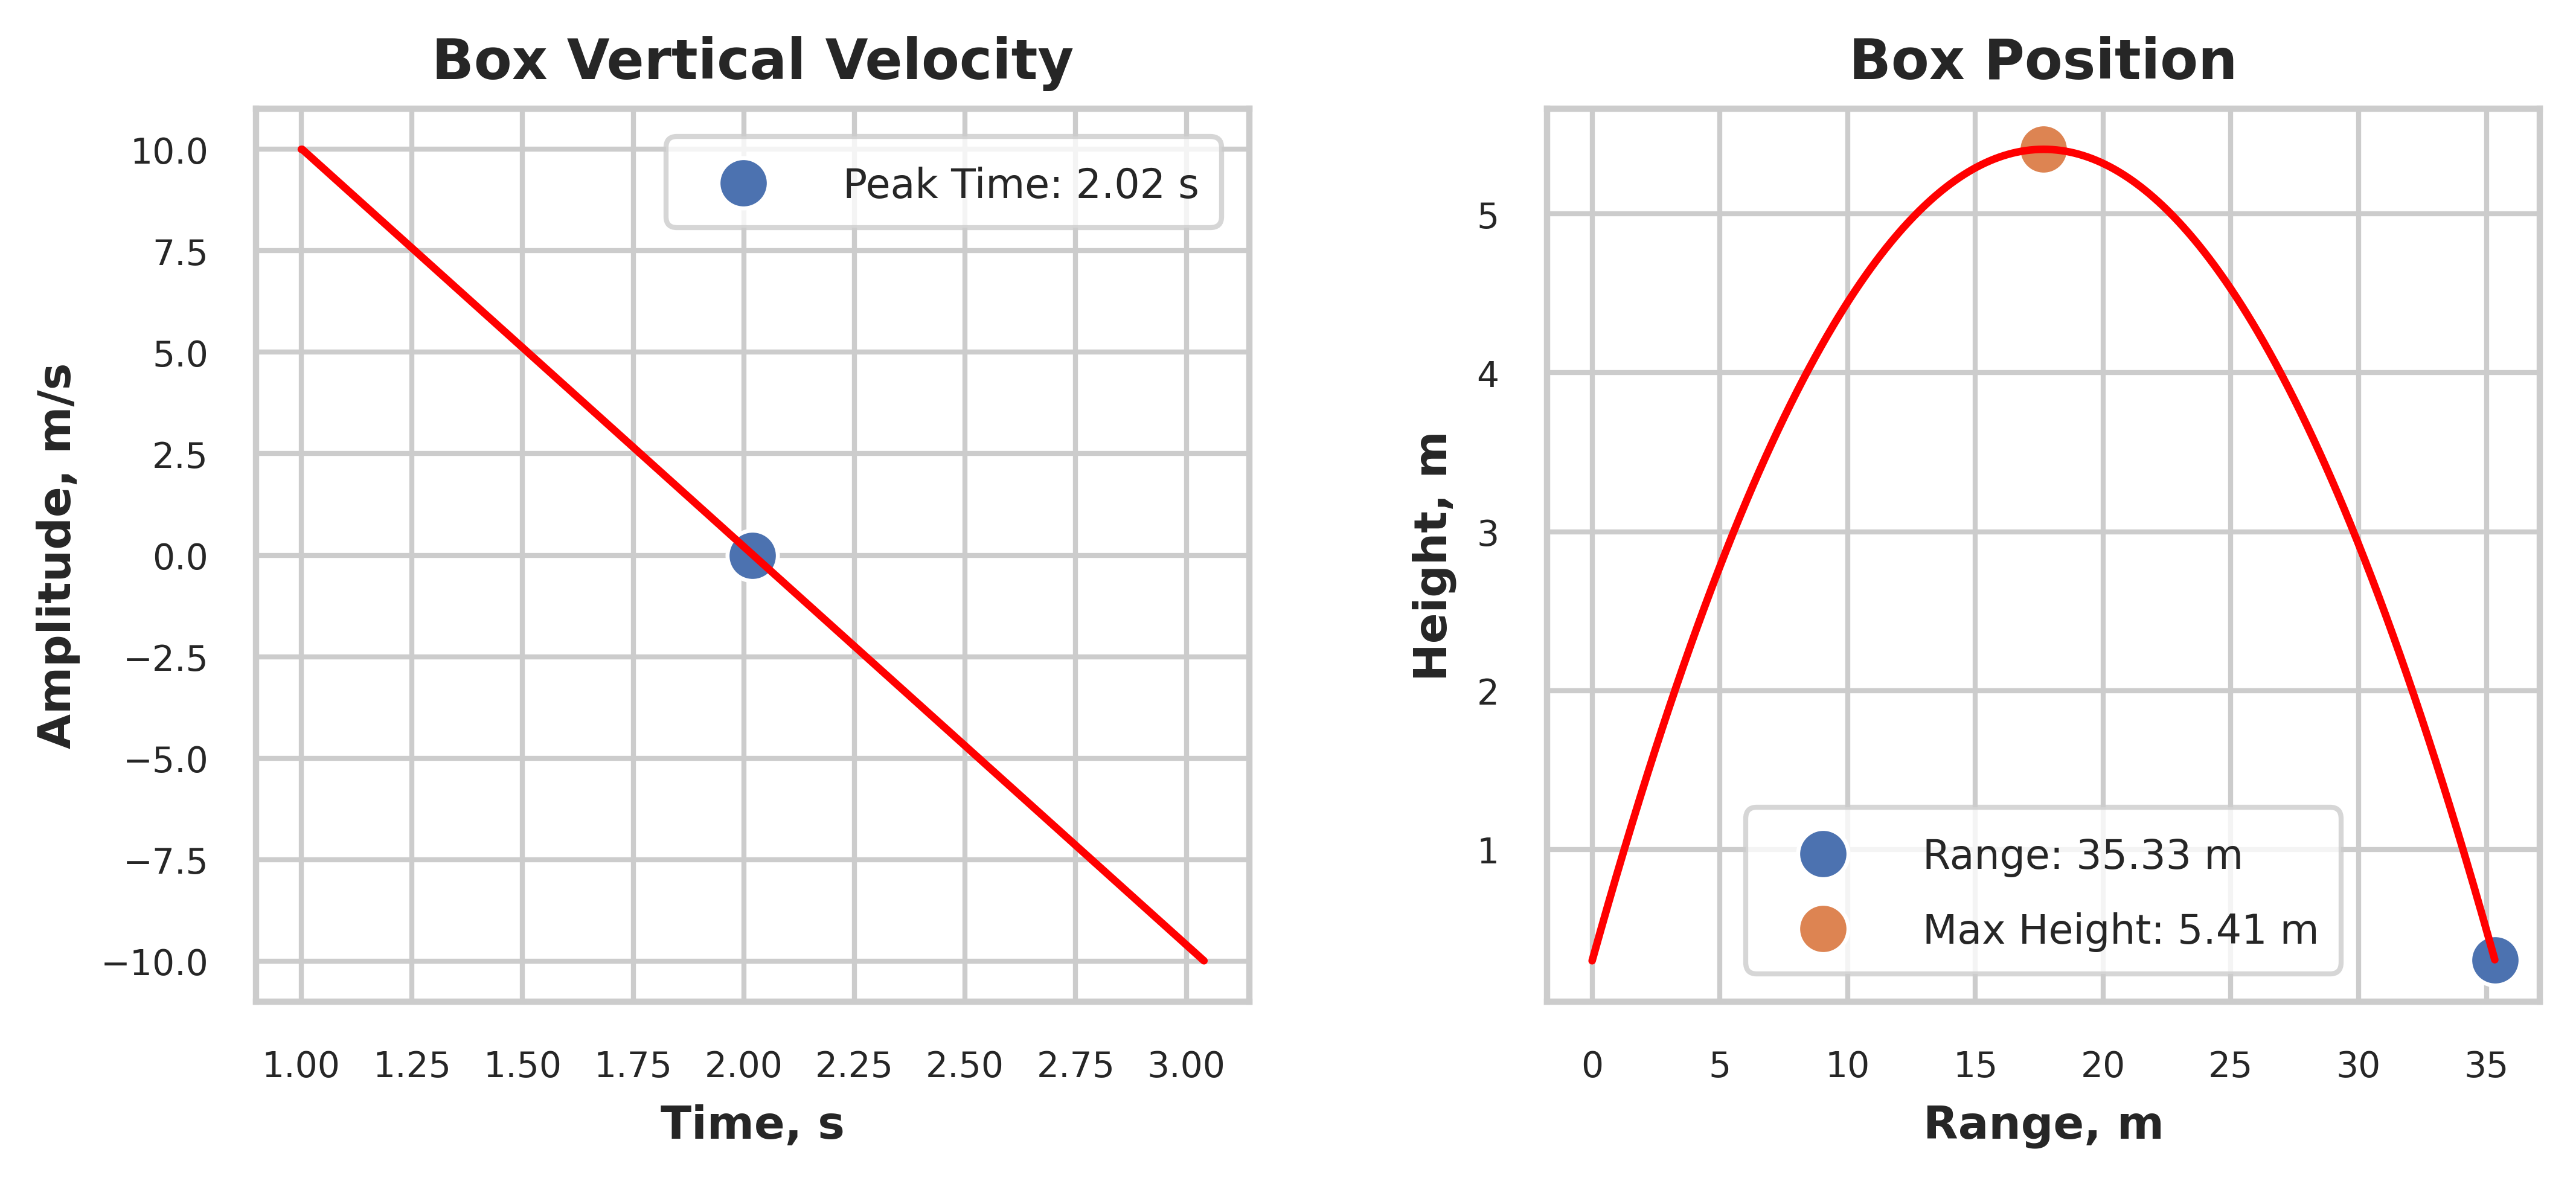

In [18]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(ncols=2, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

# position
sns.lineplot(x=position[:, 0], y=position[:, 2], ax=ax[1], color="red")
sns.scatterplot(
    x=[position[-1][0]],
    y=[position[-1][2]],
    s=100,
    ax=ax[1],
    label=f"Range: {position[-1][0]-position[0][0]:.2f} m",
)
max_height_idx = np.where(position == max(position[:, 2]))[0][0]
max_height = position[max_height_idx]
sns.scatterplot(
    x=[max_height[0]],
    y=[max_height[2]],
    s=100,
    ax=ax[1],
    label=f"Max Height: {max_height[2]:.2f} m",
)
ax[1].set_title("Box Position", weight="bold", fontsize=11)
ax[1].set_ylabel("Height, m", weight="bold", fontsize=9)
ax[1].set_xlabel("Range, m", weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)
plt.setp(ax[1].get_legend().get_texts(), fontsize="8")  # for legend text
plt.setp(ax[1].get_legend().get_title(), fontsize="8")  # for legend title

# velocity
sns.lineplot(x=timevals, y=velocity[:, 1], ax=ax[0], color="red")
sns.scatterplot(
    x=[timevals[max_height_idx]],
    y=[0],
    s=100,
    ax=ax[0],
    label=f"Peak Time: {(timevals[max_height_idx]):.2f} s",
)
ax[0].set_title("Box Vertical Velocity", weight="bold", fontsize=11)
ax[0].set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax[0].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)
plt.setp(ax[0].get_legend().get_texts(), fontsize="8")  # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize="8")  # for legend title

chart_name = f"2d_motion" if IS_COLAB else f"../../output/2d_motion"
fig.savefig(chart_name + ".png", bbox_inches="tight")